In [1]:
from model import *
from data import *

Using TensorFlow backend.


In [2]:
from importlib import reload  # Python 3.4+ only.
import data
import model as model_functions

reload(data)
reload(model_functions)

<module 'model' from 'F:\\Masterarbeit\\masterarbeit - git\\U-Net\\model.py'>

### Train with data generator

In [4]:
WIDTH = 256
HEIGHT = 256

# checkpoints
filepath="../../Models/unet/weights-improvement-{epoch:02d}-{val_loss:.4f}.h5" #-{val_f1:.2f}
# filepath="../../Models/unet/multi-label-fcDenseNet.h5"
model_checkpoint = ModelCheckpoint(filepath, save_weights_only=False, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [5]:
# data_gen_args = dict(rotation_range=0.2,
#                     width_shift_range=0.05,
#                     height_shift_range=0.05,
#                     shear_range=0.05,
#                     zoom_range=0.05,
#                     horizontal_flip=True,
#                     fill_mode='nearest')
# myGene = trainGenerator(2,'data/membrane/train','image','label',data_gen_args,save_to_dir = None)

data_gen_args = dict(
                    rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    vertical_flip=True,
                    brightness_range=[0.2,1.8],
                    #validation_split = 0.3,
                    fill_mode="reflect")

myGene = trainGenerator(10 #20
                     ,'../../Data/Masked Images/train/'
                     ,'image'
                     #,'label'
                     ,'multi-label'
                     ,data_gen_args
                     ,image_color_mode='rgb'
                     ,mask_color_mode='rgb'
                     ,target_size=(WIDTH,HEIGHT)
                     ,save_to_dir = None
                     ,flag_multi_class = True
                     ,num_class = 3
                     ,preprocessing_function=custom_preprocess_input
                       )

myGeneValidate = trainGenerator(10 #20
                     ,'../../Data/Masked Images/validate/'
                     ,'image'
                     #,'label'
                     ,'multi-label'
                     ,data_gen_args
                     ,image_color_mode='rgb'
                     ,mask_color_mode='rgb'
                     ,target_size=(WIDTH,HEIGHT)
                     ,save_to_dir = None
                     ,flag_multi_class = True
                     ,num_class = 3
                     ,preprocessing_function=custom_preprocess_input
                               )


In [1]:
from keras.preprocessing import image
import matplotlib.pyplot as plt

def set_sample_image(file_name, mask_name = None):
    if not mask_name:
        mask_name = file_name
        
    sample_image = image.load_img('../../Data/Masked Images/test/image/%s'%file_name, target_size=(HEIGHT, WIDTH))
    sample_image = image.img_to_array(sample_image)
#     sample_image /= 255
    #sample_image = np.expand_dims(sample_image, axis=0)

    sample_mask = image.load_img('../../Data/Masked Images/test/multi-label/%s'%mask_name, target_size=(HEIGHT, WIDTH))
    sample_mask = image.img_to_array(sample_mask)
    sample_mask /= 255
    #sample_mask = np.expand_dims(sample_mask, axis=0)
    
    return sample_image, sample_mask

def create_mask(pred_mask):
    pred_mask = np.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., np.newaxis]
    color_label_matrix = get_color_label_matrix(pred_mask[0])
    return color_label_matrix

def show_predictions():
    plt.figure(figsize=(20,5))
    
    plt.subplot(1, 3, 1)
    plt.title('Image')
    plt.imshow(sample_image/255)
    
    plt.subplot(1, 3, 2)
    plt.title('Ground Truth')
    plt.imshow(sample_mask)
    
    plt.subplot(1, 3, 3)
    plt.title('Predicted')
    pred = model.predict(custom_preprocess_input(sample_image)[np.newaxis, ...])
    plt.imshow(create_mask(pred)[:,:,0])# für matshow: , fignum=False
    
    return pred

Using TensorFlow backend.


In [2]:
#show_predictions()

In [11]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        #clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [19]:
model = unet(input_size=(WIDTH,HEIGHT,3), nr_classes=len(COLOR_DICT))
#n_filters_first_conv=48, n_pool=4, growth_rate=12, n_layers_per_block=5, dropout_p=0.2
# model = model_functions.fc_dense_net(input_size=(WIDTH,HEIGHT,3), nr_classes=len(COLOR_DICT), n_filters_first_conv=64, n_pool=4, growth_rate=32, n_layers_per_block=2, dropout_p=0.0)
# import tensorflow as tf
# from keras.models import load_model
# model = load_model('../../Models/unet/4multi-label cce val-loss 0.2805.h5', custom_objects={'softMaxAxis1': softMaxAxis1, 'mean_io_u': tf.keras.metrics.MeanIoU})

In [15]:
# model.compile(optimizer = Adam(lr = 1e-4), loss = 'categorical_crossentropy', metrics = ['accuracy', tf.keras.metrics.MeanIoU(num_classes=nr_classes)])

In [16]:
from keras.utils import plot_model
plot_model(model)

ImportError: Failed to import `pydot`. Please install `pydot`. For example with `pip install pydot`.

In [20]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_49 (Conv2D)              (None, 256, 256, 64) 1792        input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_50 (Conv2D)              (None, 256, 256, 64) 36928       conv2d_49[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_9 (MaxPooling2D)  (None, 128, 128, 64) 0           conv2d_50[0][0]                  
____________________________________________________________________________________________

In [21]:
#model.load_weights('../../Models/unet/4multi-label cce val-loss 0.3122.h5')

In [22]:
model.fit_generator(myGene
                    , validation_data=myGeneValidate
                    , validation_steps=20
                    , steps_per_epoch=30#60
                    , epochs=20
                    , callbacks=[model_checkpoint]) # steps_per_epoch=2000 , DisplayCallback()
#10:00

Epoch 1/20
30/30 [==============================] - 1324s 44s/step - loss: 0.9331 - accuracy: 0.6466 - mean_io_u_2: 0.3750 - val_loss: 0.6823 - val_accuracy: 0.7542 - val_mean_io_u_2: 0.3750

Epoch 00001: val_loss improved from inf to 0.68233, saving model to ../../Models/unet/weights-improvement-01-0.6823.h5
Epoch 2/20
30/30 [==============================] - 1308s 44s/step - loss: 0.8109 - accuracy: 0.7045 - mean_io_u_2: 0.3750 - val_loss: 0.7030 - val_accuracy: 0.7799 - val_mean_io_u_2: 0.3750

Epoch 00002: val_loss did not improve from 0.68233
Epoch 3/20
30/30 [==============================] - 1310s 44s/step - loss: 0.7077 - accuracy: 0.7531 - mean_io_u_2: 0.3750 - val_loss: 0.5775 - val_accuracy: 0.8069 - val_mean_io_u_2: 0.3750

Epoch 00003: val_loss improved from 0.68233 to 0.57754, saving model to ../../Models/unet/weights-improvement-03-0.5775.h5
Epoch 4/20
30/30 [==============================] - 1308s 44s/step - loss: 0.6498 - accuracy: 0.7612 - mean_io_u_2: 0.3750 - val_lo

In [ ]:
model.loss

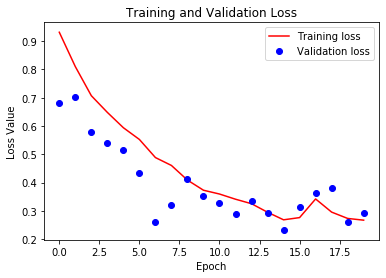

In [23]:
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

plt.figure()
plt.plot(range(len(loss)), loss, 'r', label='Training loss')
plt.plot(range(len(val_loss)), val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.show()

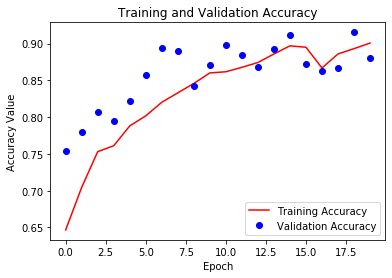

In [24]:
accuracy = model.history.history['accuracy']
val_accuracy = model.history.history['val_accuracy']

plt.figure()
plt.plot(range(len(accuracy)), accuracy, 'r', label='Training Accuracy')
plt.plot(range(len(val_accuracy)), val_accuracy, 'bo', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Value')
plt.legend()
plt.show()

In [10]:
model.save('../../Models/unet/4multi-label cce.h5')

### test your model and save predicted results

In [232]:
from keras.models import load_model
model = load_model("../../Models/unet/4multi-label cce val-loss 0.2460.h5", custom_objects={'softMaxAxis1': softMaxAxis1})

In [5]:
model = unet(input_size=(WIDTH,HEIGHT,3), nr_classes=len(COLOR_DICT))
model.load_weights('../../Models/unet/4multi-label cce val-loss 0.2269.h5')

In [42]:
from keras.preprocessing import image

img = image.load_img('../../Data/Masked Images/test/image/DJI_0227.JPG', target_size=(HEIGHT, WIDTH))
x = image.img_to_array(img)
#x /= 255
x = custom_preprocess_input(x)
x = np.expand_dims(x, axis=0)

pred = model.predict(x)#x[tf.newaxis, ...]

FileNotFoundError: [Errno 2] No such file or directory: '../../Data/Masked Images/test/image/DJI_0227.JPG'

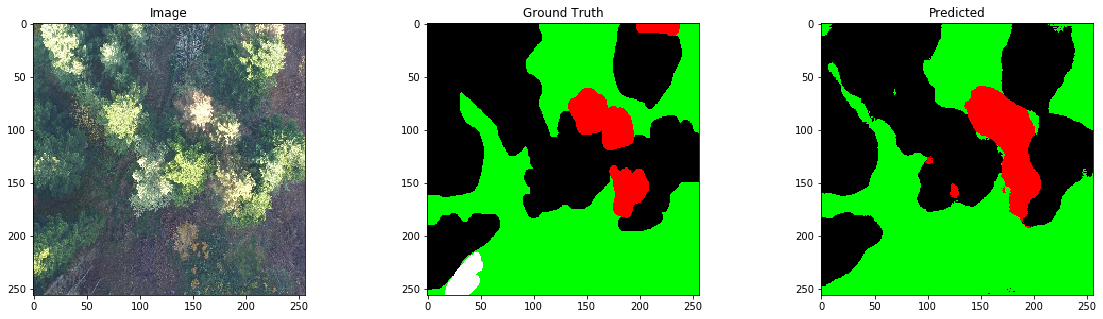

In [31]:
sample_image, sample_mask = set_sample_image('DJI_0219.JPG','DJI_0219.png')
pred = show_predictions()

Text(0.5, 1.0, 'dead')

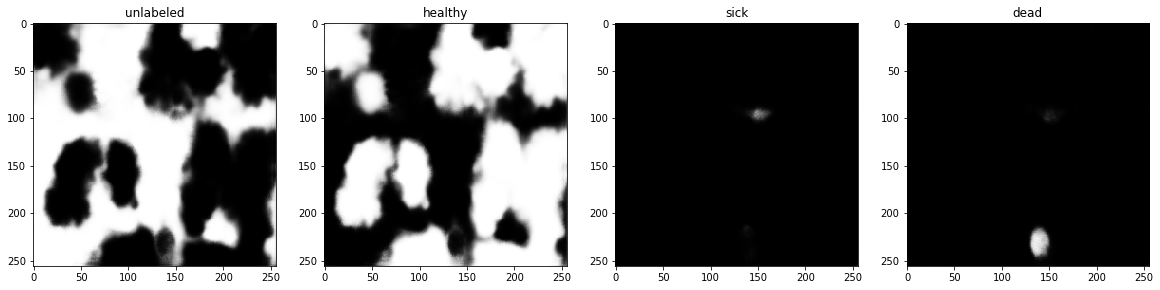

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,5))

plt.subplot(1, 4, 1)
plt.imshow(pred[0, :,:, 0], vmin=0, vmax=1, cmap='gray')
plt.title('unlabeled')

plt.subplot(1, 4, 2)
plt.imshow(pred[0, :,:, 1], vmin=0, vmax=1, cmap='gray')
plt.title('healthy')

plt.subplot(1, 4, 3)
plt.imshow(pred[0, :,:, 2], vmin=0, vmax=1, cmap='gray')
plt.title('sick')

plt.subplot(1,4,4)
plt.imshow(pred[0, :,:, 3], vmin=0, vmax=1, cmap='gray')
plt.title('dead')


In [51]:
# data_gen_args = dict(rotation_range=0.2,
#                     width_shift_range=0.05,
#                     height_shift_range=0.05,
#                     shear_range=0.05,
#                     zoom_range=0.05,
#                     horizontal_flip=True,
#                     vertical_flip=True,
#                     brightness_range=[0.2,1.8],
#                     #validation_split = 0.3,
#                     fill_mode="reflect")
data_gen_args = {preprocessing_function=custom_preprocess_input}

myTestGen = trainGenerator(16
                     ,'../../Data/Masked Images/test/'
                     ,'image'
                     #,'label'
                     ,'multi-label'
                     ,data_gen_args
                     ,image_color_mode='rgb'
                     ,mask_color_mode='rgb'
                     ,target_size=(WIDTH,HEIGHT)
                     ,save_to_dir = None
                     ,flag_multi_class = True
                       )

test_model = model
#test_model = unet()
#test_model.load_weights("unet_membrane.hdf5")
results = test_model.evaluate_generator(myTestGen, steps=16, verbose=1)

Found 8 images belonging to 1 classes.
Found 8 images belonging to 1 classes.
16/16 [==============================] - 309s 19s/step


In [52]:
results

[0.9419333934783936, 0.6002483367919922, 0.375]

In [53]:
test_model.metrics_names

['loss', 'accuracy', 'mean_io_u_8']

In [221]:
new_model = unet(input_size=(WIDTH,HEIGHT,3), nr_classes=len(COLOR_DICT))
new_model.load_weights("../../Models/unet/4multi-label cce val-loss 0.2460.h5")
#new_model.set_weights(model.get_weights())
#new_model = load_model("../../Models/unet/4multi-label cce val-loss 0.2460.h5", custom_objects={'softMaxAxis1': softMaxAxis1})

In [222]:
new_model.fit_generator(myGene
                    , validation_data=myGeneValidate
                    , validation_steps=20
                    , steps_per_epoch=60
                    , epochs=20)

Epoch 1/20
12/60 [=====>........................] - ETA: 1:37:07 - loss: 0.6782 - accuracy: 0.7999 - mean_io_u_1: 0.4399

KeyboardInterrupt: 

In [12]:
import io
img = image.load_img('../../Data/Masked Images/test/image/DJI_0241.JPG', target_size=(HEIGHT, WIDTH)) 
img = image.img_to_array(img)
mask = image.load_img('../../Data/Masked Images/test/multi-label/DJI_0241.png', target_size=(HEIGHT, WIDTH))
mask = image.img_to_array(mask)
img, mask = adjustData(img[np.newaxis,...], mask[np.newaxis,...], flag_multi_class=True, num_class=4)
img.shape, mask.shape

((1, 256, 256, 3), (1, 256, 256, 4))

In [13]:
pred = model.predict(img)
pred = np.round(pred)
pred.shape

(1, 256, 256, 4)

In [14]:
def my_meanIOU(pred, mask): # takes masks in shape of (bach_size, WIDTH, HEIGHT, NR_CLASSES)
    assert(pred.shape == mask.shape)
    intersection = np.bitwise_and(pred.astype('uint16'), mask.astype('uint16')).sum(tuple(range(pred.ndim - 1)))
    union = np.bitwise_or(pred.astype('uint16'), mask.astype('uint16')).sum(tuple(range(pred.ndim - 1)))
    return np.nanmean(intersection/union)

In [15]:
my_meanIOU(pred,mask)

0.5608510934844565

In [16]:
import eval_segm

In [17]:
eval_segm.frequency_weighted_IU(pred.argmax(-1)[0], mask.argmax(-1)[0]) # have to turn it to two dimensional matrix

0.8562931508784333

In [18]:
eval_segm.mean_IU(pred.argmax(-1)[0], mask.argmax(-1)[0]) # have to turn it to two dimensional matrix

0.7481790517210906

In [19]:
def confusion_matrix(eval_segm, gt_segm, **kwargs):
    merged_maps = np.bitwise_or(np.left_shift(gt_segm.astype('uint16'), 8), eval_segm.astype('uint16'))
    hist = np.bincount(np.ravel(merged_maps))
    nonzero = np.nonzero(hist)[0]
    pred, label = np.bitwise_and(255, nonzero), np.right_shift(nonzero, 8)
    class_count = np.array([pred, label]).max() + 1
    conf_matrix = np.zeros([class_count, class_count], dtype='uint64')
    conf_matrix.put(pred * class_count + label, hist[nonzero])
    return conf_matrix

In [20]:
cf = confusion_matrix(pred.argmax(-1)[0], mask.argmax(-1)[0]) # have to turn it to two dimensional matrix

In [21]:
cf

array([[28686,  1482,     0,   181],
       [ 3237, 31418,     0,   152],
       [   12,     0,     0,     0],
       [    0,     0,     0,   368]], dtype=uint64)

In [22]:
# precission
prec = np.diag(cf/cf.sum(1))
prec

array([0.94520413, 0.90263453, 0.        , 1.        ])

In [23]:
# recall
recall = np.diag(cf/cf.sum(0))
recall

C:\Users\Gini\Anaconda3\envs\Masterarbeit\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


array([0.89826209, 0.95495441,        nan, 0.52496434])

In [24]:
# accuracy
np.diag(cf).sum()/cf.sum()

0.9227294921875

In [25]:
(prec * recall)/(prec+recall)

array([0.46056772, 0.46402883,        nan, 0.34424696])